In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.nn import functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import random
import plotly.express as px
from sklearn.model_selection import KFold

torch.cuda.is_available()

True

# Preprocessing

In [14]:
learning_rate = 0.001
batch_size = 64
n_epoch = 10
n_split = 2
K = 1
gcn_agg = 'mean'
filter_noise = True
seed = 1234

In [3]:
train = pd.read_json("../data/train.json", lines=True)
test = pd.read_json("../data/test.json", lines=True)

if filter_noise:
    train = train[train.signal_to_noise > 1]
    
sample_df = pd.read_csv("../data/sample_submission.csv")
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
5,5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...,4.136,1,107,68,"[0.1942, 0.2041, 0.1626, 0.1213, 0.10590000000...","[0.2726, 0.2984, 0.21660000000000001, 0.1637, ...","[0.3393, 0.2728, 0.2005, 0.1703, 0.1495, 0.134...","[0.165, 0.20520000000000002, 0.179, 0.1333, 0....","[0.2864, 0.24710000000000001, 0.2222, 0.1903, ...","[0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...","[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0..."
6,6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...,2.485,1,107,68,"[0.422, 0.5478000000000001, 0.4749000000000000...","[0.4801, 0.7943, 0.42160000000000003, 0.397300...","[0.9822000000000001, 1.272, 0.6940000000000001...","[0.5827, 0.7555000000000001, 0.5949, 0.4511, 0...","[0.9306000000000001, 1.0496, 0.5844, 0.7796000...","[0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...","[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1..."
7,7,id_00b436dec,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...,.....(((((((((((..(((((((((..((((....))))..)))...,EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...,1.727,1,107,68,"[0.4843, 0.5233, 0.4554, 0.43520000000000003, ...","[0.8719, 1.0307, 0.6649, 0.34500000000000003, ...","[0.7045, 0.7775000000000001, 0.5662, 0.4561, 0...","[0.384, 0.723, 0.4766, 0.30260000000000004, 0....","[0.7429, 0.9137000000000001, 0.480400000000000...","[1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...","[1.6912, 5.2652, 2.3901, 0.45890000000000003, ...","[1.8641, 2.3767, 1.149, 1.0132, 0.9876, 0.0, 0...","[0.49060000000000004, 4.6339, 1.95860000000000...","[1.2852000000000001, 2.5460000000000003, 0.234..."


In [4]:
sample_df.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


In [5]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

def find_couples(data):
    left = [idx for idx, i in enumerate(data) if i == '(']
    right = [idx for idx, i in enumerate(data) if i == ')']

    if len(left) != len(right):
        raise ValueError("Size not matching")
    already_visited = []
    pairs = []

    for i1 in right:
        for i2 in left:
            if i2 < i1:
                if i2 not in already_visited:
                    candidate = i2
            else:
                break
        already_visited.append(candidate)
        pairs.append([candidate, i1])

    if len(pairs) != len(left):
        raise ValueError("Number of pairs doesnt match number of parenthesess")
    
    return pairs

def to_matrix(pairs, length):
    matrix = np.zeros((length, length))
    
    for i in range(length):
        if i < length - 1:
            matrix[i, i + 1] = 1
        if i > 0:
            matrix[i, i - 1] = 1
    
    for i, j in pairs:
        matrix[i, j] = 1
        matrix[j, i] = 1
        
    return matrix

def get_adj_matrix(structure):
    couples = find_couples(structure)
    mat = to_matrix(couples, len(structure))
    return mat

def preprocess(df):
    inputs = np.transpose(
        np.array(
            df[['sequence', 'structure', 'predicted_loop_type']]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )
    
    adj_matrix = np.array(df['structure'].apply(get_adj_matrix).values.tolist())
    
    return inputs, adj_matrix

# Setting up GraphSAGE

In [6]:
input_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

inputs, adjacency_matrix = preprocess(train)
labels = np.array(train[input_cols].values.tolist()).transpose((0, 2, 1))

train_inputs = torch.tensor(inputs, dtype=torch.long)
train_adj = torch.tensor(adjacency_matrix, dtype=torch.long)
train_labels = torch.tensor(labels, dtype=torch.float32)

In [7]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
# Some of this is based on approaches from other notebooks
class GCN(nn.Module):
    def __init__(self, input_dim, output_dim, aggregator='mean'):
        super(GCN, self).__init__()
        self.aggregator = aggregator

        linear_input_dim = input_dim * 2
        self.linear_gcn = nn.Linear(in_features=linear_input_dim, out_features=output_dim)
        
    def forward(self, input_, adj_matrix):
        adj_matrix = adj_matrix.type(torch.float32)
        sum_adj = torch.sum(adj_matrix, axis=2)
        sum_adj[sum_adj==0] = 1

        feature_agg = torch.bmm(adj_matrix, input_)
        feature_agg = feature_agg / sum_adj.unsqueeze(dim=2)
        feature_cat = torch.cat((input_, feature_agg), axis=2)

        feature = torch.sigmoid(self.linear_gcn(feature_cat))
        feature = feature / torch.norm(feature, p=2, dim=2).unsqueeze(dim=2)
        
        return feature
        
    
class Net(nn.Module):
    def __init__(self, num_embedding=14, seq_len=107, pred_len=68, dropout=0.5, 
                 embed_dim=100, hidden_dim=128, K=1, aggregator='mean'):
        super(Net, self).__init__()
        
        self.pred_len = pred_len
        self.embedding_layer = nn.Embedding(num_embeddings=num_embedding, 
                                      embedding_dim=embed_dim)
        
        self.gcn = nn.ModuleList([GCN(3 * embed_dim, 3 * embed_dim, aggregator=aggregator) for i in range(K)])
        
        self.gru_layer = nn.GRU(input_size=3 * embed_dim, 
                          hidden_size=hidden_dim, 
                          num_layers=3, 
                          batch_first=True, 
                          dropout=dropout, 
                          bidirectional=True)
        
        self.linear_layer = nn.Linear(in_features=2 * hidden_dim, 
                                out_features=5)
        
    def forward(self, input_, adj_matrix):
        embedding = self.embedding_layer(input_)
        embedding = torch.reshape(embedding, (-1, embedding.shape[1], embedding.shape[2] * embedding.shape[3]))

        gcn_feature = embedding
        for gcn_layer in self.gcn:
            gcn_feature = gcn_layer(gcn_feature, adj_matrix)

        gru_output, gru_hidden = self.gru_layer(gcn_feature)
        truncated = gru_output[:, :self.pred_len]
        
        output = self.linear_layer(truncated)
        
        return output

# Run

In [9]:
def train_fn(epoch, model, train_loader, criterion, optimizer):
    model.train()
    model.zero_grad()
    train_loss = AverageMeter()
    
    for index, (input_, adj, label) in enumerate(train_loader):
        input_ = input_.cuda()
        adj = adj.cuda()
        label = label.cuda()
        preds = model(input_, adj)
        
        loss = criterion(preds, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.update(loss.item())
    
    print(f"Train loss {train_loss.avg}")
    return train_loss.avg
    
def eval_fn(epoch, model, valid_loader, criterion):
    model.eval()
    eval_loss = AverageMeter()
    
    for index, (input_, adj, label) in enumerate(valid_loader):
        input_ = input_.cuda()
        adj = adj.cuda()
        label = label.cuda()
        preds = model(input_, adj)
        
        loss = criterion(preds, label)
        eval_loss.update(loss.item())
    
    print(f"Valid loss {eval_loss.avg}")
    return eval_loss.avg

In [10]:
def run(fold, train_loader, valid_loader):
    model = Net(K=K)
    model.cuda()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.0)

    train_losses = []
    eval_losses = []
    for epoch in range(n_epoch):
        print('#################')
        print('Epoch #', epoch)
        
        train_loss = train_fn(epoch, model, train_loader, criterion, optimizer)
        eval_loss = eval_fn(epoch, model, valid_loader, criterion)
        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        
    torch.save(model.state_dict(), f'../pretrain/gcn_gru_{fold}.pt')
    return train_losses, eval_losses

In [15]:
splits = KFold(n_splits=n_split, shuffle=True).split(train_inputs)

for fold, (train_idx, val_idx) in enumerate(splits):
    train_dataset = TensorDataset(train_inputs[train_idx], train_adj[train_idx], train_labels[train_idx])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    
    valid_dataset = TensorDataset(train_inputs[val_idx], train_adj[val_idx], train_labels[val_idx])
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    
    train_losses, eval_losses = run(fold, train_loader, valid_loader)

#################
Epoch # 0


KeyboardInterrupt: 

# Results

In [11]:
torch.cuda.empty_cache()

In [17]:
df = test.query("seq_length == 107").copy()
inputs, adj = preprocess(df)
inputs = torch.tensor(inputs, dtype=torch.long)
adj = torch.tensor(adj, dtype=torch.long)

In [18]:
model_short = Net(seq_len=107, pred_len=107, K=K, aggregator=gcn_agg)

list_public_preds = []

fold = n_split - 1
model_short.load_state_dict(torch.load(f'../pretrain/gcn_gru_{fold}.pt'))
model_short.cuda()
model_short.eval()

public_preds = model_short(inputs.cuda(), adj.cuda())
public_preds = public_preds.cpu().detach().numpy()

list_public_preds.append(public_preds)

In [19]:
public_preds = np.mean(list_public_preds, axis=0)

In [20]:
preds_ls = []
for df, preds in [(df, public_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]
        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)

In [29]:
preds_df.to_csv("../data/predictions", index=False)
preds_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.796480,0.817199,2.404769,0.671065,0.894505,id_00073f8be_0
1,2.038140,2.978654,3.758822,2.898176,2.457148,id_00073f8be_1
2,1.340118,0.688608,0.759216,1.042059,1.104296,id_00073f8be_2
3,1.199431,0.882305,0.879559,1.198951,1.123376,id_00073f8be_3
4,0.904199,0.709620,0.776070,0.923665,0.929978,id_00073f8be_4


# Graphs

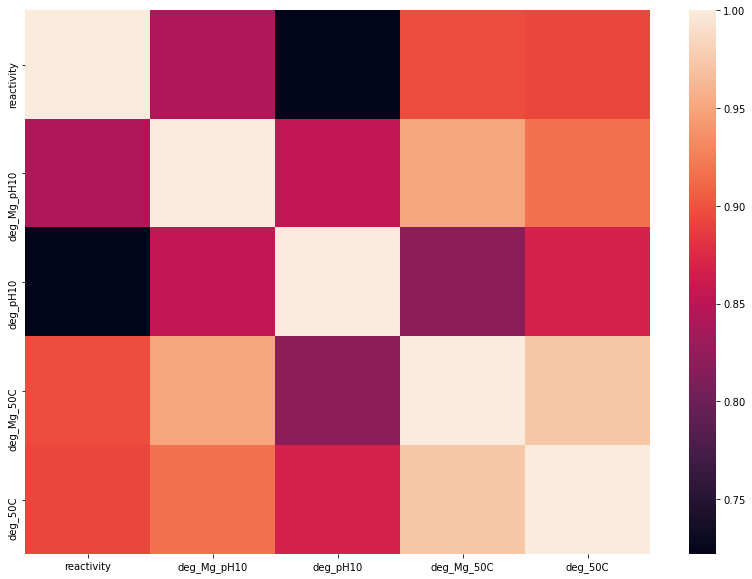

In [23]:
fig = plt.figure(figsize=(14,10))
ax = sns.heatmap(preds_df.corr())
plt.savefig('../figures/corr_heapmap')
plt.show()

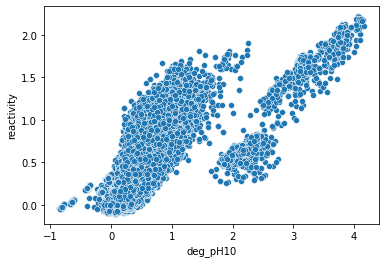

In [28]:
sns.scatterplot(data=preds_df, x="deg_pH10", y="reactivity")
plt.savefig("../figures/scatter")
plt.show()

